In [1]:
from linkedin_api import Linkedin
import numpy as np
from bs4 import BeautifulSoup
import requests
import pandas as pd
import glob
import json
import uuid
import random
from faker import Faker
import networkx as nx
import itertools
import time
from networkx.algorithms import bipartite
import unicodedata
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
def add_edge(graph,df,period,columns,period_column):
    
    df = df[df[str(period_column)] == period][columns]
    df.drop(str(period_column), axis = 1, inplace = True)
    
    for edge in df.to_records(index=False):
        graph.add_edge(*edge)
        
    return graph

def define_graph_period(period, nodes, df,columns, period_colum = 'year'):
    _period = nx.Graph()
    for node in nodes:
        _period.add_node(node)
    _period = add_edge(_period, df, period,columns, period_colum)
    return _period

def proyection_bipartite(graph, year, list_,partition):
    _temp = bipartite.projected_graph(graph,partition)
    add  = (_temp,year)
    list_.append(add)
    return list_     

In [ ]:
def random_walk_list(data_random_walk):
    #Instanciamos RandomsWords
    from wonderwords import RandomWord
    rw = RandomWord()
    
    #Leemos resultados de la simulacion
    random_walk =  pd.read_csv(data_random_walk)
    
    #Numero de nodos
    N_people = len(np.unique(random_walk.Rw))
    N_companys = len(np.unique(random_walk.N_visited))
    N_nodos = len(np.append(np.unique(random_walk.Rw),np.unique(random_walk.N_visited) ))
    
    #Creamos listas con palabras
    Words = pd.DataFrame(rw.random_words(N_nodos))
    
    #Mapamos 
    D_people = Words[0].iloc[:N_people]
    D_company = Words[0].iloc[N_people:].reset_index(drop = True)
    
    D_people = {key:value for key,value in D_people.items()}
    D_company = {random_walk.N_visited.sort_values().unique()[i]:D_company.sort_values().unique()[i] for i in range(N_companys)}
    
    random_walk.Rw = random_walk.Rw.map(D_people)
    random_walk.N_visited = random_walk.N_visited.map(D_company)
    
    #Definimos Graph
    graph = random_walk
    
    companys = graph.N_visited.unique()
    people = graph.Rw.unique()
    
    #Creamos los nodos
    nodes = np.append(np.unique(random_walk.Rw.astype(str)),np.unique(random_walk.N_visited.astype(str)) )
    
    #Creamos los grafos
    columns = ['t','Rw','N_visited']
    years = []
    graphs_list_Rw = []
    for peri-od in np.sort(graph.t.unique()):
        _temp = define_graph_period(period,nodes,graph,columns, period_colum = 't')
        _period = str(period)
        years.append(period)
        add = (_temp,_period)
        graphs_list_Rw.append(add)
        
    return graphs_list_Rw, companys, people, years,graph

def bipartite_list(list_, projector):
    graphs_list_month_Rw = []
    for graph, year in list_:
        proyection_bipartite(graph, year, graphs_list_month_Rw,projector)
    return graphs_list_month_Rw

def k_average(graph_list):
    return [pd.DataFrame(nx.degree(value)).mean().values for value,key in graph_list]

def C_average(graph_list):
    return [np.array(list(nx.clustering(value).values())).mean() for value,key in graph_list]

def second_criteria(graphs_list_Rw):
    #Segundo Criterio
    for i in range(len(graphs_list_Rw)-1):
        for edge in graphs_list_Rw[i][0].edges():
            graphs_list_Rw[i+1][0].add_edge(*edge)
    return graphs_list_Rw

# Consolidar una sola base de pefiles

In [ ]:
DF = pd.DataFrame()
for perfil in glob.glob('./Perfiles/*'):
    df = pd.read_csv(perfil)
    print(str(perfil) + "  " + str(len(df)))
    DF = pd.concat([DF,df])

In [ ]:
DF.drop(['notes', 'email',
       'phoneNumber', 'address', 'twitter1', 'twitter2', 'im1', 'im2', 'im3',
       'website1', 'website2', 'website3'], axis = 1, inplace = True)

In [ ]:
DF = DF.groupby('id').first().reset_index()*

# Creamos indice unico

In [ ]:
Faker.seed(0)

In [ ]:
DF['uuid'] = DF.apply(lambda _: Faker().uuid4()[:8], axis=1)

In [ ]:
DF.to_excel("Consolidado_perfiles.xlsx",index = False)

# Buscamos sus perfiles de Linkedin

In [94]:
DF = pd.read_excel("Consolidado_perfiles.xlsx")

In [ ]:
DF = DF[DF.index >=453]

In [ ]:
#Leemos las credenciales
with open('Requests.txt') as f:
    lines = f.readlines()

In [ ]:
# Authenticate using any Linkedin account credentials
api = Linkedin(lines[0][:-1], lines[1])

In [ ]:
for index,row in DF.iterrows():
    print(row.id,"   ",row['Unnamed: 0'])
    #GET a profile
    #time.sleep(20)
    dic = api.get_profile(row.id)['experience']
    
    if isinstance(dic, dict):
        dic['uuid'] = row.uuid
        with open('./Dic_perfiles' + '/' + str(row.id) +  '.json', 'w', encoding='utf-8') as f:
            json.dump(experience, f)
        
    else:
        contador = 0
        for experience in dic:
            experience['uuid'] = row.uuid
            with open('./Dic_perfiles' + '/' + str(row.id) + '_' + str(contador) + '.json', 'w', encoding='utf-8') as f:
                json.dump(experience, f)
            contador+=1

# Obtenemos informacion de empresas de los json

In [95]:
companys = []
time_periods_start = []
time_periods_end = []
uuid = []
locationName = []
industries = []
for work in glob.glob('./Dic_perfiles/*.json'):
    with open(work, encoding='utf-8') as json_file:
        dicts = json.load(json_file)
        
        companys.append(dicts['companyName'])

        uuid.append(dicts['uuid'])
        
        try:
            time_periods_start.append(dicts['timePeriod']['startDate'])
        except:
            time_periods_start.append(np.nan)
        
        try:
            locationName.append(dicts['locationName'])
        except:
            locationName.append(np.nan)
        try:
            time_periods_end.append(dicts['timePeriod']['endDate'])
        except:
            time_periods_end.append(np.nan)
        try:
            industries.append(dicts['company']['industries'])
        except:
            industries.append(np.nan)

In [96]:
#Verficamos el tamaño de todas las listas
print(len(companys))
print(len(time_periods_start))
print(len(time_periods_end))
print(len(uuid))
print(len(locationName))
print(len(industries))

2253
2253
2253
2253
2253
2253


In [97]:
works = pd.DataFrame({'companys':companys,
                  'StartPeriod':time_periods_start,
                  'EndPeriod':time_periods_end,
                  'uuid':uuid,
                  'Location':locationName,
                  'Industries':industries})

In [98]:
#remplamos mismos empresas
works.companys = works.companys.replace({
    "Nestle S.A.":"Nestle",
    "Dichter & Neira Research":"Dichter & Neira",
    "Deloitte Brasil":"Deloitte",
    "Deloitte México":"Deloitte",
    "Credit Suisse Brasil":"Credit Suisse",
    "Congreso Latinoamericano Tecnología y Negocios America Digital":"Latin America Digital Congress of Technology and Business",
    "Congreso Latinoamericano Tecnología y Negocios America Digital 5 y 6 Sept 20":"Latin America Digital Congress of Technology and Business",
    "Scotiabank Mexico":"Scotiabank",
    "OYO  - Brasil":"OYO",
    "OYO Brasil":"OYO",
    "Self-employed":"Independiente",
    "Profesional independiente":"Independiente",
    "Autónomo":"Independiente",
    "Profesional independiente":"Independiente",
    "Independant":"Independiente",
    "Mi propia empresa :)":"Independiente",
    ".":"Mi propia empresa :)",
    "LG Electronics Brasil":"LG Electronics",
    "BBVA en México":"BBVA",
    "BBVA en Perú":"BBVA",
    "KStore SPA - Kawke Project":"KStore - Kawke Project",
    "Merama Wellness":"Merama",
    "Accenture Brasil":"Accenture",
    "Accenture Strategy (formerly Axia Limited)":"Accenture",
    "B2W Digital":"B2W",
    "BANORTE SEGUROS Y PENSIONES":"BANORTE",
    "Caon Castro Consentino Mendonça Sociedade de Advogados":"Caon Castro Consentino Mendonça Sociedade de Advogados ",
    "Citi":"Civi",
    "Dafiti Group":"Dafiti",
    "Falabella Retail":"Falabella",
    "Falabella Retail S.A":"Falabella",
    "Grupo Modelo S.A. de C.V.":"Grupo Modelo",
    "HawkersCo":"Hawkers Group",
    "INSEAD Student Impact Fund (ISIF)":"INSEAD",
    "Indra BPO México, S. A. de C. V.":"Indra",
    "Insider Store":"Insider",
    "Johnson & Johnson Consumer Health":"Johnson & Johnson",
    "KPMG Brazil":"KPMG",
    "KPMG México":"KPGM",
    "Kavak México":"Kavak.com",
    "Laika Mascotas":"Laika app",
    "Matrix Solutions":"Matrix CMP",
    "Mercado Livre":"Mercado Libre",
    "Mercado Livre Brasil":"Mercado Libre",
    "Mercado Pago Brasil":"Mercado Libre",
    "Miind Brands (anteriormente D2Honesty) / Adquirida por Merama en el 2022":"Miind Brands",
    "Miind Brands | Digital Native Brands":"Miind Brands",
    "Miind Native Digital Brands":"Miind Brands",
    "Miind | Digital Native Brands (Formerly D2Honesty)":"Miind Brands",
    "Modloft Furniture":"Modloft",
    "Petlove&Co":"Petlove",
    "PwC Brasil":"PWC",
    "PwC Chile":"PWC",
    "PwC Colombia":"PWC",
    "RVC - Reis, Rocha e Carvalho Sociedade de Advogados":"RVC Consultores Tributário",
    "RVC Advocacia e Consultoria Tributária e Empresarial":"RVC Consultores Tributário",
    "Raken DataGroup":"Raken Data Group",
    "Raken Digital Talent":"Raken Data Group",
    "Red Latinoamericana de Transformación Digital":"Red Latinoamericana de Transformacion Digital",
    "Synapcom Full Commerce":"Synapcom",
    "Tata Consultancy Services Latinoamérica":"Tata Consultancy Services",
    "Telefónica":"Telefonica",
    "Telefónica Tech":"Telefonica",
    "Universidad Anáhuac Mayab":"Universidad Anáhuac",
    "Universidad Anáhuac Mexico Norte":"Universidad Anáhuac",
    "Universidad Anáhuac México":"Universidad Anáhuac",
    "University of California, Berkeley, Haas School of Business":"University of California",
    "University of California, San Diego - Rady School of Management":"University of California",
    "Via Varejo SA":"Via",
    "Walmart de México y Centroamérica":"Walmart",
    "Walmart eCommerce":"Walmart",
    "XP INVESTIMENTOS":"XP Inc."
})

In [99]:
#Homologamos las industrias
works.Industries = works.Industries.apply(lambda x: x[0] if isinstance(x,list) else np.nan)
works.Industries = works.Industries.fillna('SinIndustria')
works.Industries = works.Industries.str.replace(',',' ')
works.Industries = works.Industries.apply(lambda x: unicodedata.normalize("NFKD", x).encode("ascii","ignore").decode("ascii"))
works.Industries = works.Industries.str.replace(' ',"")

In [100]:
#Quitamos comas y acentos
works.companys = works.companys.str.replace(',',' ')
works.companys = works.companys.apply(lambda x: unicodedata.normalize("NFKD", x).encode("ascii","ignore").decode("ascii"))
works.companys = works.companys.str.replace(' ',"")

In [101]:
#Desconcatenamos fechas
works['StartMonth'] = works.StartPeriod.apply(lambda x: x.get('month') if isinstance(x,dict) else np.nan)
works['StartYear'] = works.StartPeriod.apply(lambda x: x.get('year') if isinstance(x,dict) else np.nan)
works['EndMonth'] = works.EndPeriod.apply(lambda x: x.get('month') if isinstance(x,dict) else np.nan)
works['EndYear'] = works.EndPeriod.apply(lambda x: x.get('year') if isinstance(x,dict) else np.nan)

In [102]:
#Eliminamos las columnas que ya no nos sirven
works.drop(['StartPeriod','EndPeriod'], axis = 1,inplace = True)

In [103]:
#Donde la EndDate sea nula ponemos 2022 asumiendo que siguen en ese trabajo
works.EndYear = works.EndYear.fillna(2022)

In [104]:
#Quitamos los regitros que no tienen fecha de entrada
works = works[works['StartYear'].notna()]

In [105]:
#Numero de años por trabajo
works['TotalYears'] = (works.EndYear - works.StartYear).astype(int)

In [106]:
works['StartMonth'] = works['StartMonth'].fillna(1)
works['EndMonth'] = works['EndMonth'].fillna(12)

In [107]:
works['StartMonthPeriod'] = pd.to_datetime(works.StartMonth.astype(int).astype(str) + works.StartYear.astype(int).astype(str),format = '%m%Y')
works['EndMonthPeriod'] = pd.to_datetime(works.EndMonth.astype(int).astype(str) + works.EndYear.astype(int).astype(str),format = '%m%Y')

In [108]:
works['TotalMonths'] = round((works['EndMonthPeriod'] - works['StartMonthPeriod'])/np.timedelta64(1, 'M'))

In [109]:
works.TotalMonths = works.TotalMonths.astype(int)

In [110]:
DF_to_adjacency_matrix_month = pd.DataFrame()

for index,row in works.iterrows():
    
    if row.TotalMonths == 0:
        temp = pd.DataFrame({
            'uuid':[row.uuid],
            'company': [row.companys],
            'period':[row.StartMonthPeriod],
            'industry':[row.Industries]
        })
        
        DF_to_adjacency_matrix_month = pd.concat([DF_to_adjacency_matrix_month,temp])
        
    else:
        for i in range(row.TotalMonths):
            temp = pd.DataFrame({
                'uuid':[row.uuid],
                'company': [row.companys],
                'period':[row.StartMonthPeriod],
                'industry':[row.Industries]
            })
            
            row.StartMonthPeriod = row.StartMonthPeriod + relativedelta(months=1) 
            DF_to_adjacency_matrix_month = pd.concat([DF_to_adjacency_matrix_month,temp])

In [111]:
DF_to_adjacency_matrix = pd.DataFrame()

for index,row in works.iterrows():
    #print(row.StartYear)
    
    if row.TotalYears == 0:
        temp = pd.DataFrame({
            'uuid':[row.uuid],
            'company': [row.companys],
            'year':[row.EndYear],
            'industry':[row.Industries]
        })
        
        DF_to_adjacency_matrix = pd.concat([DF_to_adjacency_matrix,temp])
        
    else:
        StartYear = row.StartYear
        for i in range(row.TotalYears):
            
            temp = pd.DataFrame({
                'uuid':[row.uuid],
                'company': [row.companys],
                'year':[StartYear],
                'industry':[row.Industries]
            })
            
            StartYear += 1
            DF_to_adjacency_matrix = pd.concat([DF_to_adjacency_matrix,temp])

In [112]:
print(len(np.unique(DF_to_adjacency_matrix.uuid)))
len(np.unique(DF_to_adjacency_matrix.company))

481


1089

In [113]:
DF_to_adjacency_matrix = DF_to_adjacency_matrix.drop_duplicates()

In [ ]:
DF_to_adjacency_matrix.to_excel('DF_to_adjacency_matrix.xlsx',index = False)

In [114]:
DF_to_adjacency_matrix_month.period = DF_to_adjacency_matrix_month.period.dt.strftime("%Y-%m")

In [ ]:
DF_to_adjacency_matrix_month.to_excel('DF_to_adjacency_matrix_month.xlsx',index = False)

# Creamos la red por año

In [ ]:
uuids = pd.read_csv('uuids merama.csv')

In [ ]:
DF_to_adjacency_matrix = pd.read_excel('DF_to_adjacency_matrix.xlsx')

In [ ]:
DF_to_adjacency_matrix = DF_to_adjacency_matrix[DF_to_adjacency_matrix.uuid.isin(uuids.uuid)]

In [ ]:
#Seleecionamos año
graph = DF_to_adjacency_matrix[DF_to_adjacency_matrix.year >= 2010]

In [ ]:
nodes = np.append(np.unique(graph.uuid),np.unique(graph.company) )

In [ ]:
columns = ['year','uuid','company']
years = []
graphs_list = []
for year in np.sort(graph.year.unique()):
    _temp = define_graph_period(year,nodes,graph,columns)
    _year = str(year)
    years.append(year)
    add = (_temp,_year)
    graphs_list.append(add)

# Dos personas se encuentran en la misma empresa en el mismo año

In [ ]:
companys = graph.company.unique()
people = graph.uuid.unique()
marker = itertools.cycle(('.', '+', '.', 'o', '*',"v","^","<",">","1","2","3","4")) 

In [ ]:
#Companys
graphs_list_c = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_c,companys)

In [ ]:
#People
graphs_list_p = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_p, people)

In [ ]:
#Grado por año
for graph_,label in graphs_list:
    degree = pd.DataFrame(nx.degree(graph_))[1]
    val, freq = np.unique(degree, return_counts=True)
    plt.loglog(val,freq,label = str(label), marker = next(marker), linestyle='')

plt.xlabel(r'$k$')
plt.ylabel(r'$f(k)$')
plt.legend()
plt.show()

In [ ]:
#Grado por año empresas
for graph_,label in graphs_list_c:
    degree = pd.DataFrame(nx.degree(graph_))[1]
    val, freq = np.unique(degree, return_counts=True)
    plt.loglog(val,freq,label = str(label), marker = next(marker), linestyle='')

plt.xlabel(r'$k$')
plt.ylabel(r'$f(k)$')
plt.legend()
plt.show()

In [ ]:
#Grado por año Personas
plt.figure(3,figsize=(10,10)) 
for graph_,label in graphs_list_p:
    degree = pd.DataFrame(nx.degree(graph_))[1]
    val, freq = np.unique(degree, return_counts=True)
    plt.loglog(val,freq,label = str(label), marker = next(marker), linestyle='')

plt.xlabel(r'$k$')
plt.ylabel(r'$f(k)$')
plt.legend()
plt.show()

In [ ]:
#Primer criterio (Dos personas se encuentran en la misma empresa el mismo año)

In [ ]:
Gcc = sorted(nx.connected_components(_2020_p), key=len, reverse=True)
G0 = _2020_p.subgraph(Gcc[0])

In [ ]:
nx.draw_networkx??

In [ ]:
nx.draw_networks¿x

In [ ]:
#Evolucion de la <k> y <C>
k_average_c_1  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_c]
k_average_p_1  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_p]
C_average_c_1  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_c]
C_average_p_1  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_p]

# Dos personas que se encuentran en una empresa sin importar el año

In [ ]:
for i in range(len(graphs_list)-1):
    for edge in graphs_list[i][0].edges():
        graphs_list[i+1][0].add_edge(*edge)

In [ ]:
#Companys
graphs_list_c_2 = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_c_2,companys)

In [ ]:
#People
graphs_list_p_2 = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_p_2, people)

In [ ]:
#Grado por año
for graph_,label in graphs_list:
    degree = pd.DataFrame(nx.degree(graph_))[1]
    val, freq = np.unique(degree, return_counts=True)
    plt.loglog(val,freq,label = str(label), marker = next(marker), linestyle='')

plt.xlabel(r'$k$')
plt.ylabel(r'$f(k)$')
plt.legend()
plt.show()

In [ ]:
#Grado por año empresas
for graph_,label in graphs_list_c_2:
    degree = pd.DataFrame(nx.degree(graph_))[1]
    val, freq = np.unique(degree, return_counts=True)
    plt.loglog(val,freq,label = str(label), marker = next(marker), linestyle='')

plt.xlabel(r'$k$')
plt.ylabel(r'$f(k)$')
plt.legend()
plt.show()

In [ ]:
#Grado por año Personas
plt.figure(3,figsize=(10,10)) 
for graph_,label in graphs_list_p_2:
    degree = pd.DataFrame(nx.degree(graph_))[1]
    val, freq = np.unique(degree, return_counts=True)
    plt.loglog(val,freq,label = str(label), marker = next(marker), linestyle='')

plt.xlabel(r'$k$')
plt.ylabel(r'$f(k)$')
plt.legend()
plt.show()

In [ ]:
#Evolucion de la <k> y <C>
k_average_c_2  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_c_2]
k_average_p_2  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_p_2]
C_average_c_2  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_c_2]
C_average_p_2  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_p_2]

In [ ]:
review = graphs_list_p[8][0]
Gcc = sorted(nx.connected_components(review), key=len, reverse=True)
G0 = review.subgraph(Gcc[0])

In [ ]:
plt.figure(3,figsize=(20,20)) 
nx.draw(G0,with_labels = True )

In [ ]:
years

In [ ]:
review = graphs_list_p[10][0]
Gcc = sorted(nx.connected_components(review), key=len, reverse=True)
G0 = review.subgraph(Gcc[0])

In [ ]:
plt.figure(3,figsize=(20,20)) 
nx.draw(G0,with_labels = True )

In [ ]:
G0.edges()

In [ ]:
DF_to_adjacency_matrix[DF_to_adjacency_matrix.company == "PortoSeguro"]

In [ ]:
DF_to_adjacency_matrix[DF_to_adjacency_matrix.company == "Deloitte"]

In [ ]:
DF_to_adjacency_matrix[DF_to_adjacency_matrix.uuid.isin(["74f8c57b"])].sort_values('year')

In [ ]:
DF_to_adjacency_matrix[DF_to_adjacency_matrix.uuid.isin(["51497435"])].sort_values('year')       

In [ ]:
DF_to_adjacency_matrix[DF_to_adjacency_matrix.uuid.isin(["88653e42"])].sort_values('year')

# Graficas

In [ ]:
# K promedio compañias 
plt.plot(years, k_average_c_2, label = 'Criterio 2')
plt.plot(years, k_average_c_1, label = 'Criterio 1')
plt.legend()
plt.plot()

In [ ]:
# K promedio personas 
plt.plot(years, k_average_p_2, label = 'Criterio 2')
plt.plot(years, k_average_p_1, label = 'Criterio 1')
plt.legend()
plt.plot()

In [ ]:
# C promedio personas 
plt.plot(years, C_average_p_2, label = 'Criterio 2')
plt.plot(years, C_average_p_1, label = 'Criterio 1')
plt.legend()
plt.plot()

In [ ]:
# C promedio personas 
plt.plot(years, C_average_c_2, label = 'Criterio 2')
plt.plot(years, C_average_c_1, label = 'Criterio 1')
plt.legend()
plt.plot()

# Creamos las redes por mes

In [286]:
#Leemos los archivos
uuids = pd.read_csv('uuids merama.csv')
DF_to_adjacency_matrix_month = pd.read_excel('DF_to_adjacency_matrix_month.xlsx',index = False)

In [287]:
#Seleccionamos los que esten en merama
DF_to_adjacency_matrix_month = DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.uuid.isin(uuids.uuid)]

In [288]:
#Cambios
P_period = DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.period <= '2020-10']

In [289]:
changes = []
P_period_df = pd.DataFrame()
for uuid in P_period.uuid.unique():
    _aux = P_period[P_period.uuid == uuid].sort_values('period').reset_index(drop = True)
    changes.append(0)
    for row in range(len(_aux)-1):
        #print(_aux.iloc[row + 1])
        if _aux.iloc[row + 1].company != _aux.iloc[row].company:
            changes.append(1)
            #print('*'*20)
        else:
            changes.append(0)
    P_period_df = pd.concat([P_period_df,_aux])

In [299]:
P_period_df[P_period_df.changes == 1]

,index,uuid,company,period,industry,changes
22,24,f16f1487,OrestiaS.A.deC.V.,2015-05,BuildingMaterials,1
26,150,ac825818,AT&T,2017-08,Telecommunications,1
46,146,ac825818,Cabify,2019-05,ComputerSoftware,1
50,122,ac825818,Privalia,2019-10,ComputerSoftware,1
10,217,e02a35e9,MOBOMEXICO,2019-06,Retail,1
...,...,...,...,...,...,...
1,44095,4c1f59df,4Student,2018-12,RealEstate,1
3,44082,4c1f59df,NestAssetManagement,2020-05,InvestmentManagement,1
34,44312,23aa9e67,TodoLlavesAVC.A.,2013-09,SinIndustria,1
77,44281,23aa9e67,mobileHUT,2017-08,SinIndustria,1


In [302]:
P_period_df[P_period_df.uuid == 'ac825818'].iloc[:-50]

,index,uuid,company,period,industry,changes
0,170,ac825818,sertecamericanexpress,2015-05,SinIndustria,0
1,171,ac825818,sertecamericanexpress,2015-06,SinIndustria,0
2,172,ac825818,sertecamericanexpress,2015-07,SinIndustria,0
3,173,ac825818,sertecamericanexpress,2015-08,SinIndustria,0
4,174,ac825818,sertecamericanexpress,2015-09,SinIndustria,0
5,175,ac825818,sertecamericanexpress,2015-10,SinIndustria,0
6,176,ac825818,sertecamericanexpress,2015-11,SinIndustria,0
7,177,ac825818,sertecamericanexpress,2015-12,SinIndustria,0
8,178,ac825818,sertecamericanexpress,2016-01,SinIndustria,0
9,179,ac825818,sertecamericanexpress,2016-02,SinIndustria,0


In [291]:
P_period_df['changes'] = changes

In [292]:
P_de_cambio = pd.pivot_table(P_period_df, index = 'period', columns = 'changes', values = 'uuid', aggfunc = 'count').fillna(0)

In [293]:
P_de_cambio['total'] = P_de_cambio[0] + P_de_cambio[1]

In [294]:
dist_de_cambio = P_de_cambio[1]/P_de_cambio['total']

In [295]:
#Creamos los bins
#Usando la regla de Freedamn.Diaconis
q25, q75 = np.percentile(dist_de_cambio, [25, 75])
bin_width = 2 * (q75 - q25) * (len(dist_de_cambio) ** (-1/3))
bins = round((dist_de_cambio.max() - dist_de_cambio.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

Freedman–Diaconis number of bins: 21


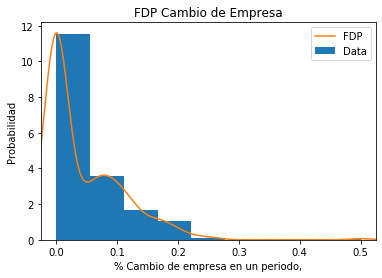

In [296]:
import scipy.stats as st

plt.hist(dist_de_cambio, density=1, bins=9, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(dist_de_cambio)
plt.plot(kde_xs, kde.pdf(kde_xs), label="FDP")
plt.legend(loc="upper right")
plt.ylabel("Probabilidad")
plt.xlabel("% Cambio de empresa en un periodo,")
plt.title("FDP Cambio de Empresa");

In [283]:
#Probabilidad de cambiarse 
dist_de_cambio.mean()

0.059763388040595486

In [256]:
#Seleccinamos todo lo mayor a 2010
graph = DF_to_adjacency_matrix_month[DF_to_adjacency_matrix_month.period >= '2010-01']

In [257]:
#Valores
print("Total personas", graph.uuid.nunique())
print("Total compañias", graph.company.nunique())
print("Total periodos", graph.period.nunique())

Total personas 386
Total compañias 848
Total periodos 155


In [258]:
#Creamos los nodos
nodes = np.append(np.unique(graph.uuid),np.unique(graph.company) )

In [259]:
columns = ['period','uuid','company']
years = []
graphs_list = []
for period in np.sort(graph.period.unique()):
    _temp = define_graph_period(period,nodes,graph,columns, period_colum = 'period')
    _period = str(period)
    years.append(period)
    add = (_temp,_period)
    graphs_list.append(add)

In [260]:
companys = graph.company.unique()
people = graph.uuid.unique()

In [261]:
#Companys
graphs_list_c_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_c_month,companys)

In [262]:
#People
graphs_list_p_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_p_month, people)

In [263]:
#Evolucion de la <k> y <C>
k_average_c_1_month  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_c_month]
k_average_p_1_month  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_p_month]
C_average_c_1_month  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_c_month]
C_average_p_1_month  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_p_month]

In [264]:
#Segundo Criterio
for i in range(len(graphs_list)-1):
    for edge in graphs_list[i][0].edges():
        graphs_list[i+1][0].add_edge(*edge)

In [265]:
#Companys
graphs_list_c_2_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_c_2_month,companys)

In [266]:
#People
graphs_list_p_2_month = []
for graph, year in graphs_list:
    proyection_bipartite(graph, year, graphs_list_p_2_month, people)

In [267]:
#Evolucion de la <k> y <C>
k_average_c_2_month  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_c_2_month]
k_average_p_2_month  = [pd.DataFrame(nx.degree(value)).mean().values for value,key in graphs_list_p_2_month]
C_average_c_2_month  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_c_2_month]
C_average_p_2_month  = [np.array(list(nx.clustering(value).values())).mean() for value,key in graphs_list_p_2_month]

# Graficas mensuales

[]

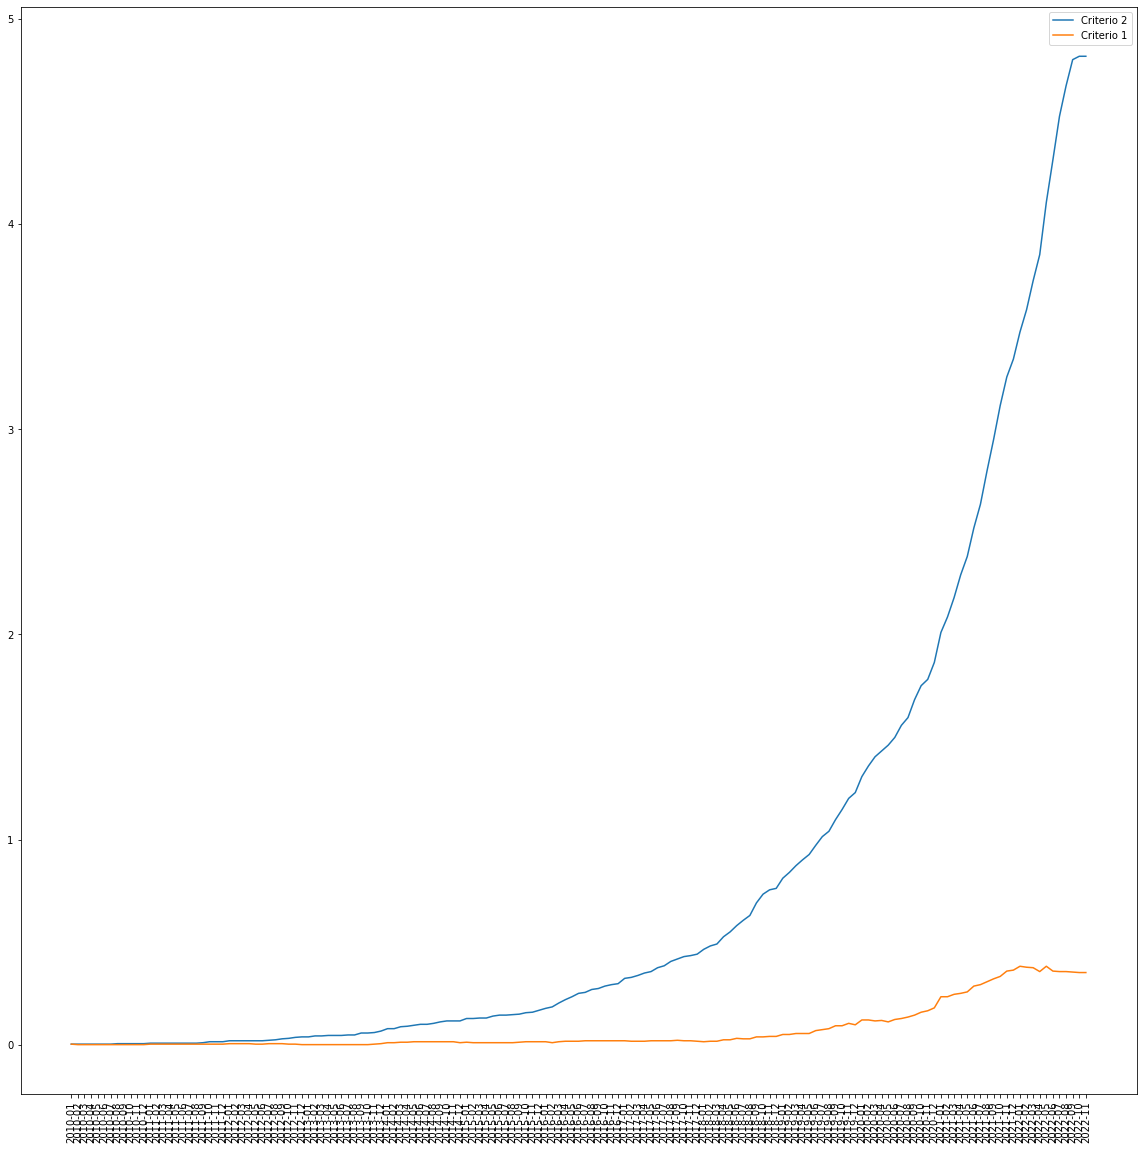

In [273]:
# K promedio compañias 
plt.figure(3,figsize=(20,20)) 
plt.plot(years, k_average_c_2_month, label = 'Criterio 2')
plt.plot(years, k_average_c_1_month, label = 'Criterio 1')
plt.xticks(rotation = 90)
plt.legend()
plt.plot()

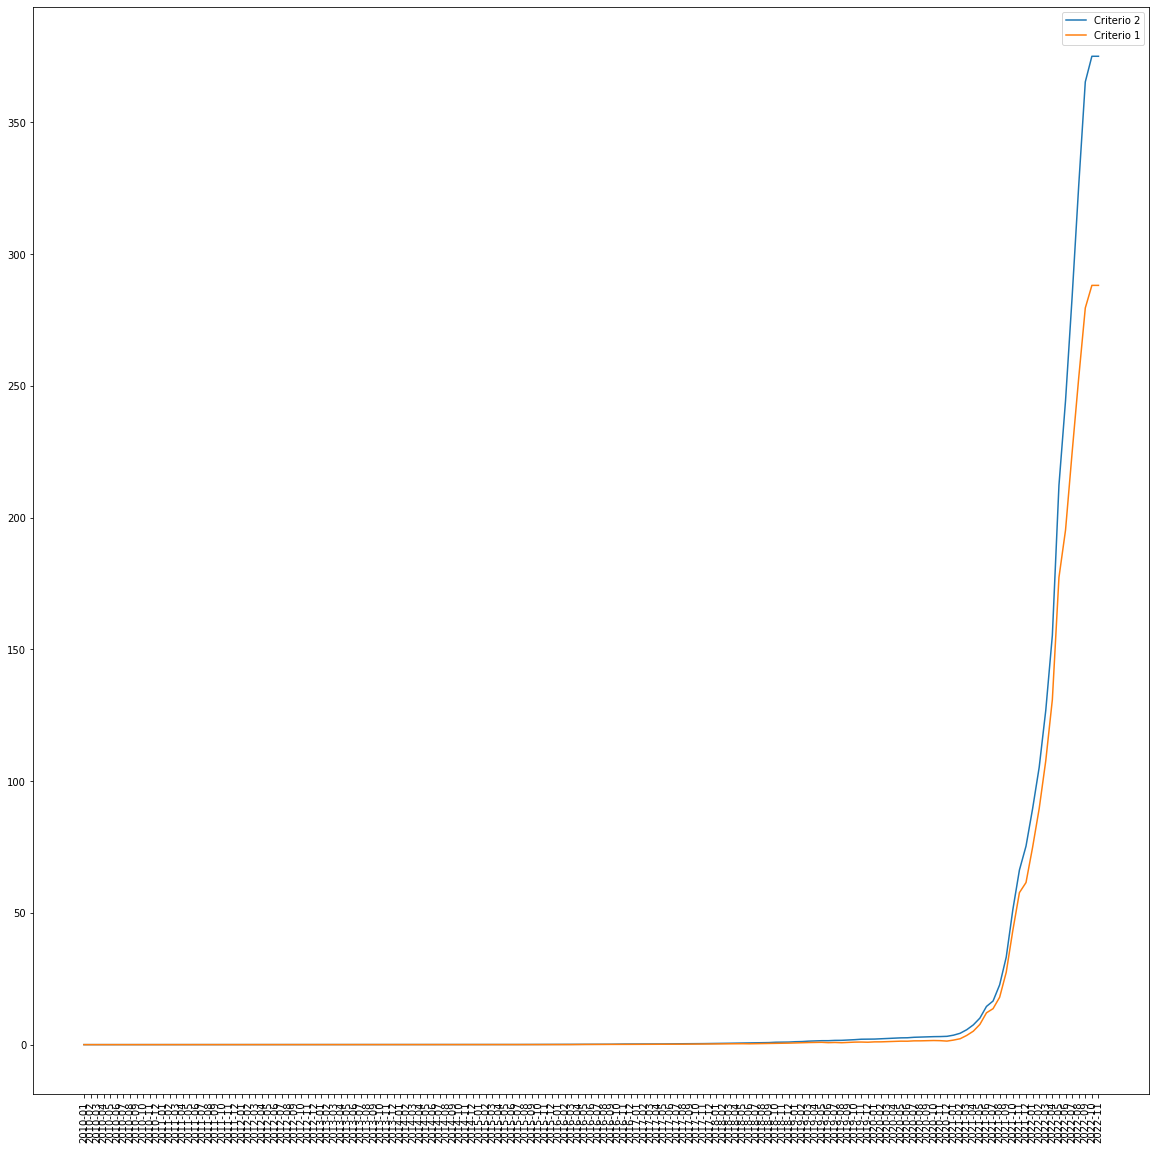

In [270]:
# K promedio personas 
plt.figure(3,figsize=(20,20)) 
plt.plot(years, k_average_p_2_month, label = 'Criterio 2')
plt.plot(years, k_average_p_1_month, label = 'Criterio 1')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

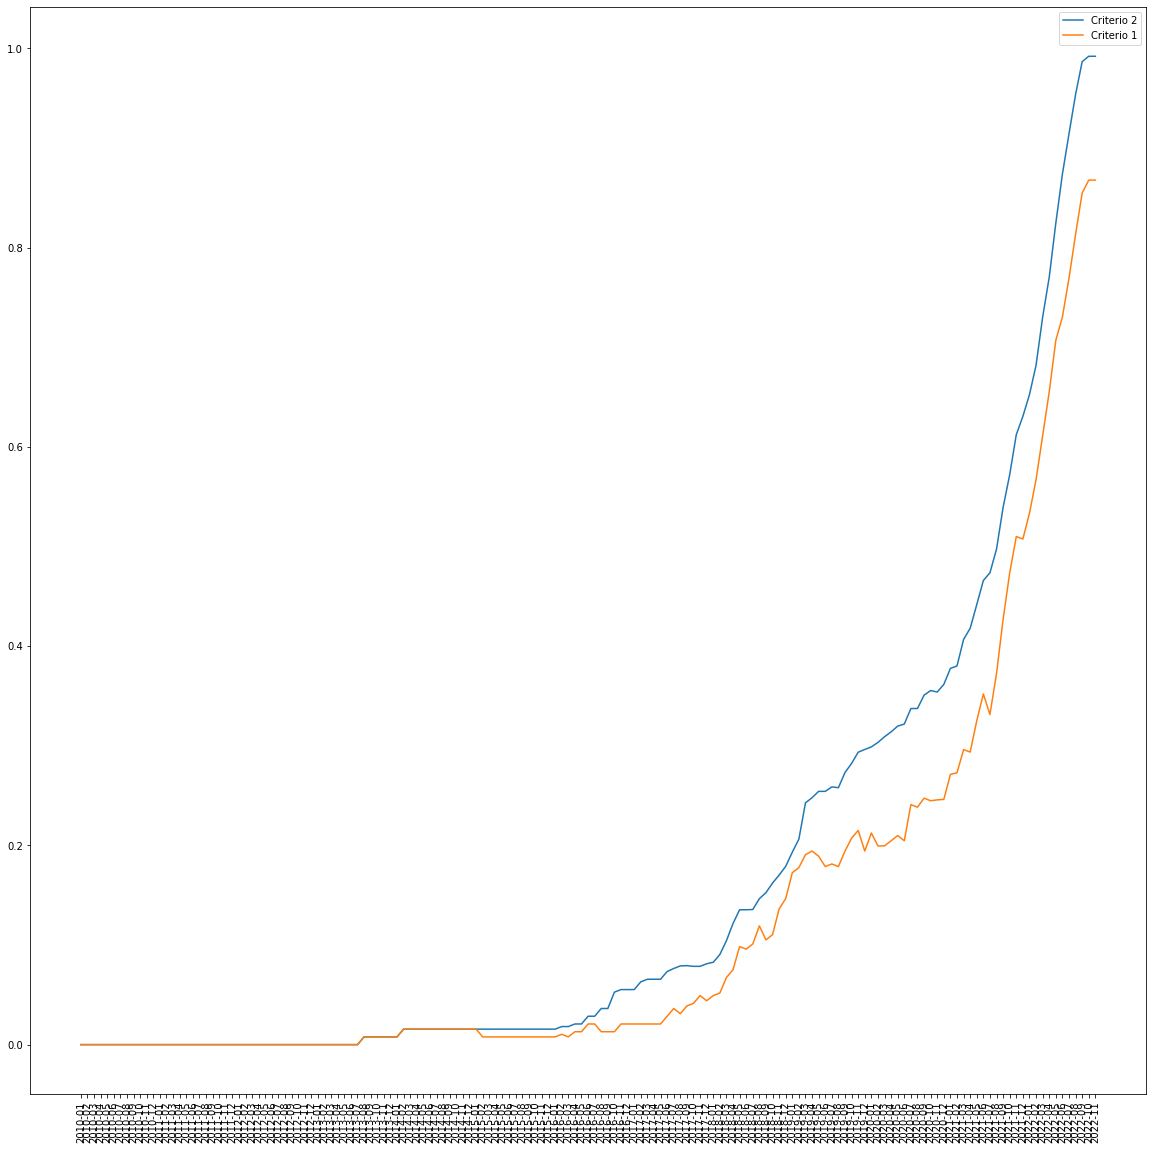

In [271]:
# C promedio personas 
plt.figure(3,figsize=(20,20)) 
plt.plot(years, C_average_p_2_month, label = 'Criterio 2')
plt.plot(years, C_average_p_1_month, label = 'Criterio 1')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

[]

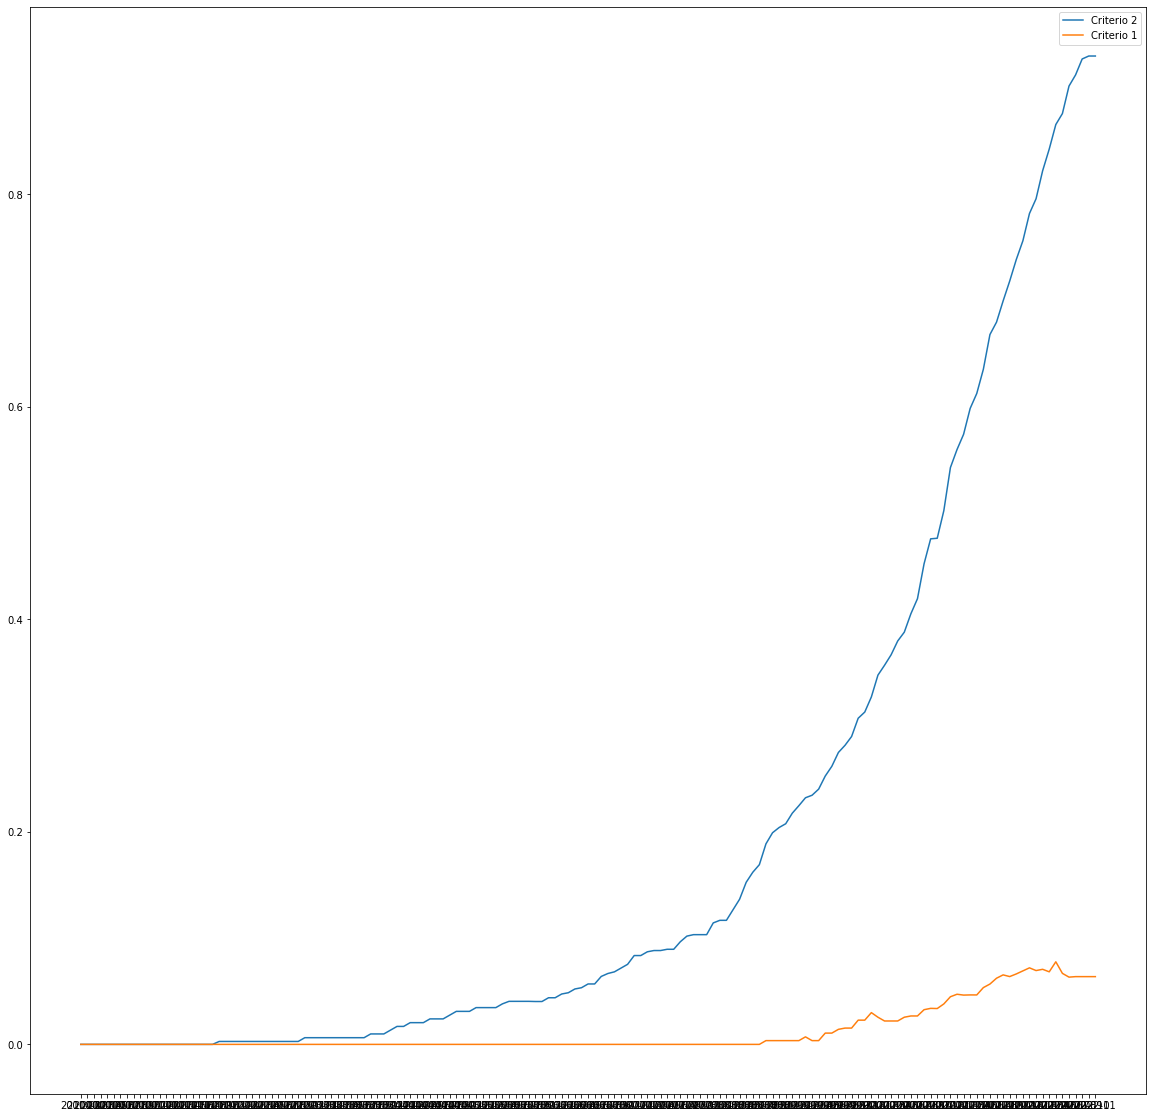

In [272]:
# C promedio empresas 
plt.figure(3,figsize=(20,20)) 
plt.plot(years, C_average_c_2_month, label = 'Criterio 2')
plt.plot(years, C_average_c_1_month, label = 'Criterio 1')
plt.legend()
plt.plot()

In [294]:
#Gigant component
def gigant_componente(list_, size):
    sizes = []
    for element, date in list_:
        Gcc = sorted(nx.connected_components(element), key=len, reverse=True)
        G0 = review.subgraph(Gcc[0])
        sizes.append(len(G0)/size)
    return sizes

In [297]:
#Componente gigante
gc_people_month_1 = gigant_componente(graphs_list_p_month,386)
gc_people_month_2= gigant_componente(graphs_list_p_2_month,386)

[]

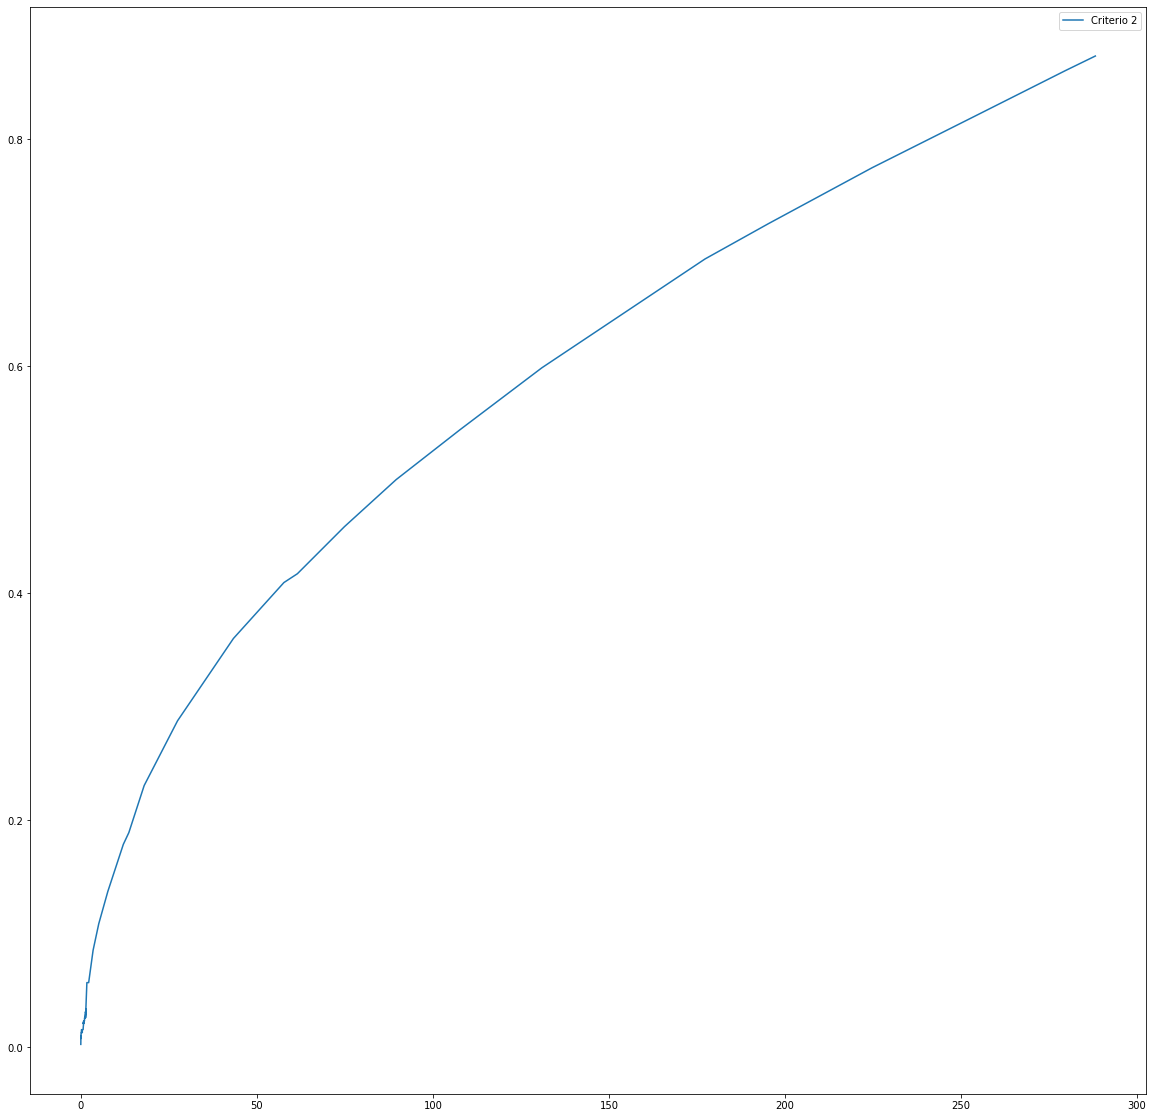

In [299]:
# Componente gigante empresas 
plt.figure(3,figsize=(20,20)) 
plt.plot(k_average_p_1_month, gc_people_month_1, label = 'Criterio 1')
#plt.plot(k_average_p_1_month, gc_people_month_2, label = 'Criterio 1')
plt.legend()
plt.plot()

[]

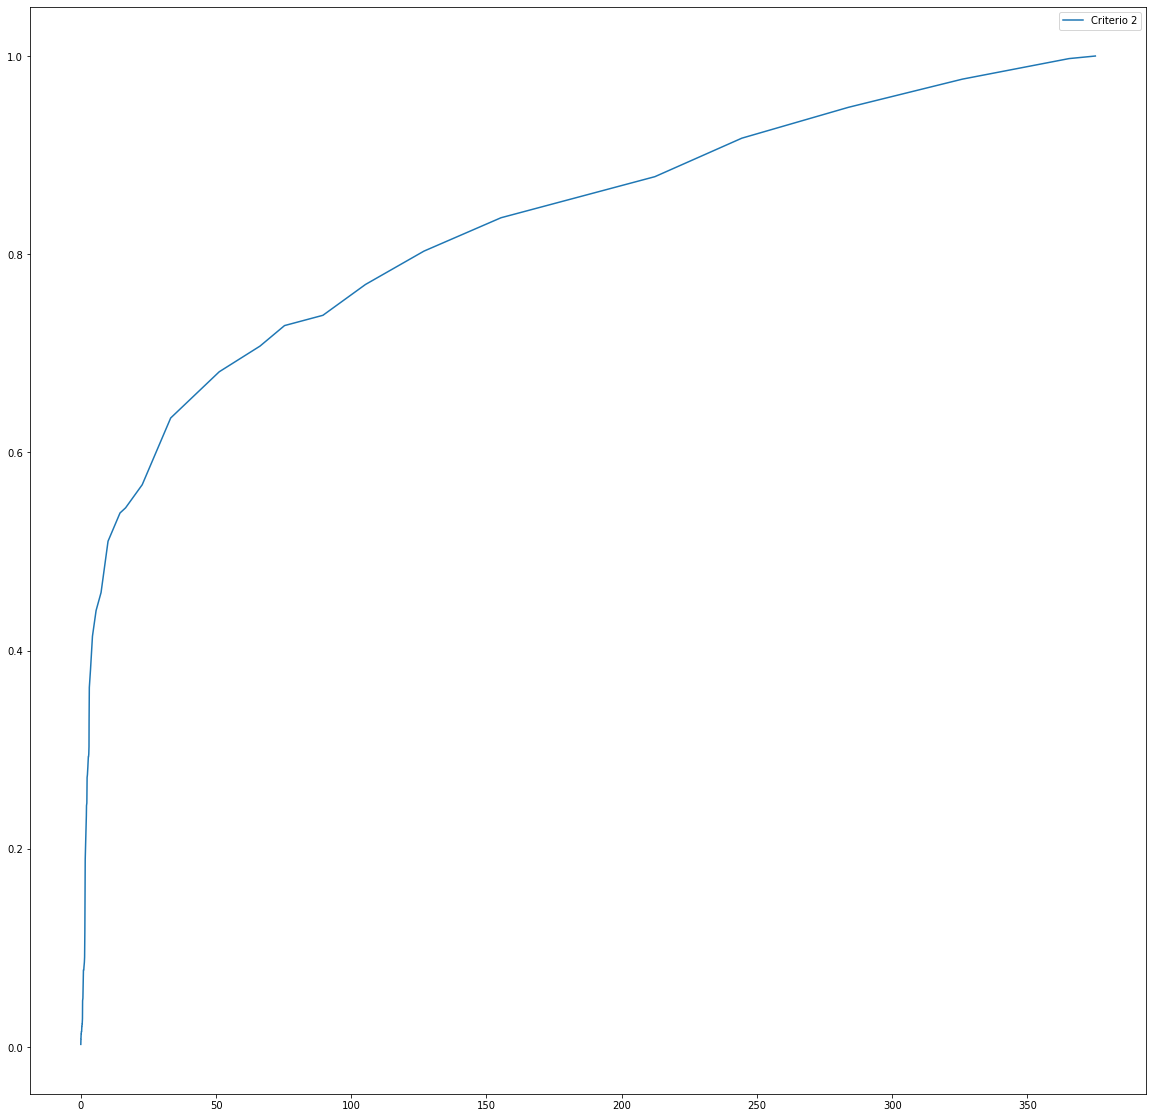

In [301]:
# Componente gigante empresas 
plt.figure(3,figsize=(20,20)) 
#plt.plot(k_average_p_1_month, gc_people_month_1, label = 'Criterio 2')
plt.plot(k_average_p_2_month, gc_people_month_2, label = 'Criterio 2')
plt.legend()
plt.plot()

In [ ]:
graphs_list_p_month

In [289]:
len(Gcc)/386

0.12694300518134716

In [282]:
review = graphs_list_p_month[154][0]
Gcc = sorted(nx.connected_components(review), key=len, reverse=True)
G0 = review.subgraph(Gcc[0])

In [ ]:
for i in range(len(graphs_list_p_month)):
    print(i,"    ", graphs_list_p_month[i][1])

# Verificacion de probabilidad

In [414]:
for random_walk in glob.glob('./Visits_Rw/*.dat'):
    #Leemos resultados de la simulacion
    random_walk =  pd.read_csv(random_walk)
    Rws = []
    N_visiteds = []
    ts = []
    for Rw in random_walk.Rw.unique():
        _aux = random_walk[random_walk.Rw == Rw].reset_index()
        time = 0
        for row in range(len(_aux.t)-1):
            Rws.append(Rw)
            if _aux.iloc[row + 1].N_visited != _aux.iloc[row].N_visited:
                N_visiteds.append(_aux.iloc[row].N_visited)
                ts.append(time)
            else:
                N_visiteds.append(_aux.iloc[row].N_visited)
                ts.append(time) 
                time += 1
    random_walk_df = pd.DataFrame({'Rw':Rws,'N_visited':N_visiteds,'t':ts})
    P_period = random_walk_df.groupby(['Rw','t']).nunique()['N_visited'].reset_index()[['Rw','t','N_visited']]
    cambiaron = P_period[P_period.N_visited >= 2].groupby('t').nunique()['Rw']
    quedaron = P_period.groupby('t').nunique()['Rw']
    dist_periodo = cambiaron/quedaron
    #probabilidad promedio de cambiarse
    print(dist_periodo.mean())

0.3260962584007855
0.30116163799978374
0.2897310607524877
0.22647159631446906
0.12136057582305455
0.05051716252413307
0.3272494023810208
0.28870657847602316
0.24523501028736738
0.19509962651415338
0.1009398643203032
0.04002414648834035
0.2685444035050914
0.259717130338699
0.23652084950698776
0.16439216357603342
0.08212700708207489
0.029494227825709016
0.178013582308665
0.18739019867795384
0.17111115349172318
0.1256597341628831
0.060619891653080266
0.02021616666512569
0.10397453496828912
0.10494839456206362
0.11007186123514995
0.08658755364348454
0.043133992030979056
0.010344349674474665
nan
nan
nan
nan
nan
nan


# Homologacion de periodos y cambios de empresa

In [ ]:
#Creamos funcion que homologa periodos

In [ ]:
#Leemos resultados de la simulacion
random_walk =  pd.read_csv('./Visits_Rw/Rw_0.950000_0.950000.dat')

In [ ]:
random_walk =  pd.read_csv(random_walk)
Rws = []
N_visiteds = []
ts = []
    for Rw in random_walk.Rw.unique():
        _aux = random_walk[random_walk.Rw == Rw].reset_index()
        time = 0
        for row in range(len(_aux.t)-1):
            Rws.append(Rw)
            if _aux.iloc[row + 1].N_visited != _aux.iloc[row].N_visited:
                N_visiteds.append(_aux.iloc[row].N_visited)
                ts.append(time)
            else:
                N_visiteds.append(_aux.iloc[row].N_visited)
                ts.append(time) 
                time += 1
                random_walk_df = pd.DataFrame({'Rw':Rws,'N_visited':N_visiteds,'t':ts})

# Random Walk

In [254]:
#Leemos el grafo
graphs_list_Rw, companys, people, years, df = random_walk_list('./Visits_Rw/Prueba.dat')

In [257]:
#Companys
graphs_list_c_month_Rw = bipartite_list(graphs_list_Rw, companys)

In [258]:
#People
graphs_list_p_month_Rw = bipartite_list(graphs_list_Rw, people)

In [242]:
#K average
k_average_c_1_month_Rw = k_average(graphs_list_c_month_Rw)
k_average_p_1_month_Rw = k_average(graphs_list_p_month_Rw)

In [243]:
#C average
C_average_c_1_month_Rw  = C_average(graphs_list_c_month_Rw)
C_average_p_1_month_Rw  = C_average(graphs_list_p_month_Rw)

In [244]:
#Segundo Criterio
graphs_list_Rw_2 = second_criteria(graphs_list_Rw)

In [245]:
#Companys
graphs_list_c_2_month_Rw = bipartite_list(graphs_list_Rw_2, companys)

In [246]:
#People
graphs_list_p_2_month_Rw = bipartite_list(graphs_list_Rw_2, people)

In [247]:
#K average
k_average_c_2_month_Rw = k_average(graphs_list_c_2_month_Rw)
k_average_p_2_month_Rw = k_average(graphs_list_p_2_month_Rw)
#C average
C_average_c_2_month_Rw  = C_average(graphs_list_c_2_month_Rw)
C_average_p_2_month_Rw  = C_average(graphs_list_p_2_month_Rw)

# Graficas RW

pd.DataFrame({'<k>_p':k_average_p_2_month_Rw,
              '<K>_c':k_average_c_2_month_Rw,
              '<c>_p':C_average_p_2_month_Rw,
              '<c>_c':C_average_c_2_month_Rw}).to_csv('mean_coeficients_first_probe.txt')

In [259]:
graphs_list_p_month_Rw

[(<networkx.classes.graph.Graph at 0x2722641cac8>, '0'),
 (<networkx.classes.graph.Graph at 0x27226f7fb48>, '1'),
 (<networkx.classes.graph.Graph at 0x2724e5ad848>, '2'),
 (<networkx.classes.graph.Graph at 0x2723c2667c8>, '3'),
 (<networkx.classes.graph.Graph at 0x2722c30bf48>, '4'),
 (<networkx.classes.graph.Graph at 0x2724e5ad188>, '5'),
 (<networkx.classes.graph.Graph at 0x2724e5adb48>, '6'),
 (<networkx.classes.graph.Graph at 0x2724e5adfc8>, '7'),
 (<networkx.classes.graph.Graph at 0x2724e5ad348>, '8'),
 (<networkx.classes.graph.Graph at 0x2724e5ad508>, '9'),
 (<networkx.classes.graph.Graph at 0x2724e5ad708>, '10'),
 (<networkx.classes.graph.Graph at 0x2724e5ad088>, '11'),
 (<networkx.classes.graph.Graph at 0x2724e5ad788>, '12'),
 (<networkx.classes.graph.Graph at 0x27226f7d348>, '13'),
 (<networkx.classes.graph.Graph at 0x27226f7d3c8>, '14'),
 (<networkx.classes.graph.Graph at 0x2722a226908>, '15'),
 (<networkx.classes.graph.Graph at 0x2722a226bc8>, '16'),
 (<networkx.classes.grap

In [277]:
review = graphs_list_p_month_Rw[155][0]
Gcc = sorted(nx.connected_components(review), key=len, reverse=True)
G0 = review.subgraph(Gcc[0])

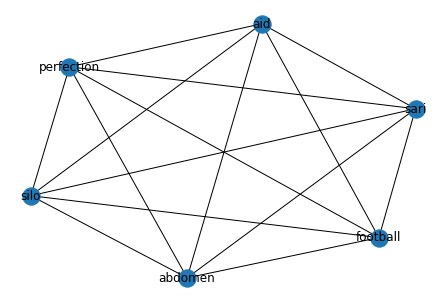

In [278]:
nx.draw(G0, with_labels = True)

In [286]:
df[(df.N_visited == "denim") & (df.t == 155)]

,Rw,N_visited,t
15443,aid,denim,155
24959,perfection,denim,155
31199,sari,denim,155
54131,abdomen,denim,155
56003,silo,denim,155
56627,football,denim,155


In [285]:
df[(df.Rw == "abdomen") & (df.t == 155)]

,Rw,N_visited,t
54131,abdomen,denim,155


In [ ]:
#Borra antes de aqui

Text(0, 0.5, '$\\langle K \\rangle$')

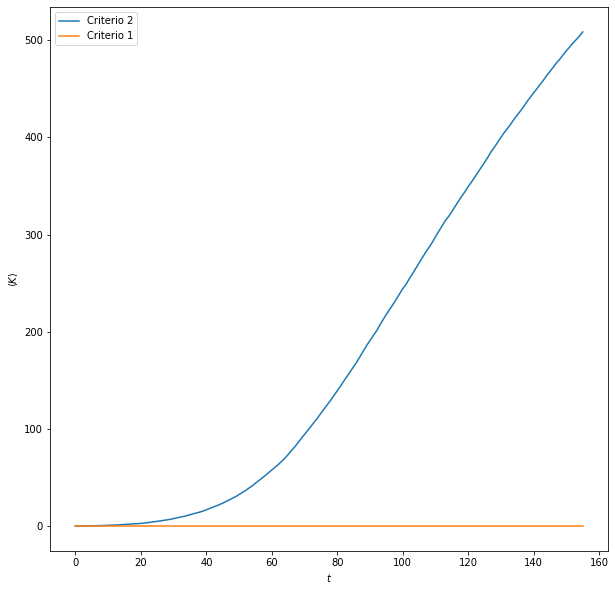

In [279]:
# K promedio compañias 
plt.figure(3,figsize=(10,10)) 
plt.plot(years, k_average_c_2_month_Rw, label = 'Criterio 2')
plt.plot(years, k_average_c_1_month_Rw, label = 'Criterio 1')
plt.legend()
plt.plot()
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle K \rangle$')

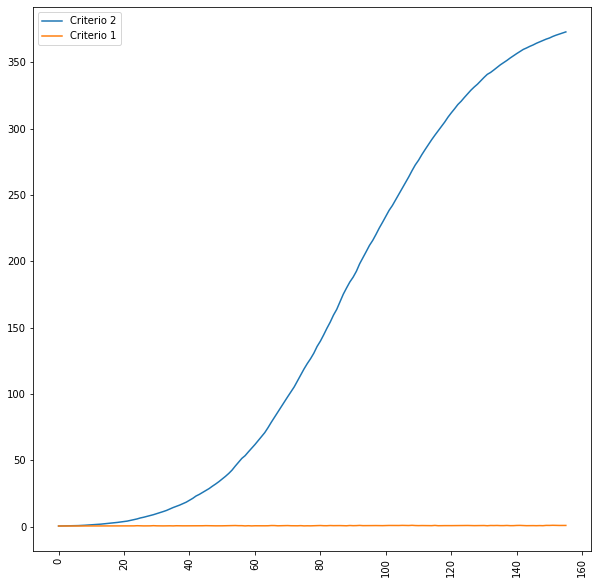

In [249]:
# K promedio personas 
plt.figure(3,figsize=(10,10)) 
plt.plot(years, k_average_p_2_month_Rw, label = 'Criterio 2')
plt.plot(years, k_average_p_1_month_Rw, label = 'Criterio 1')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

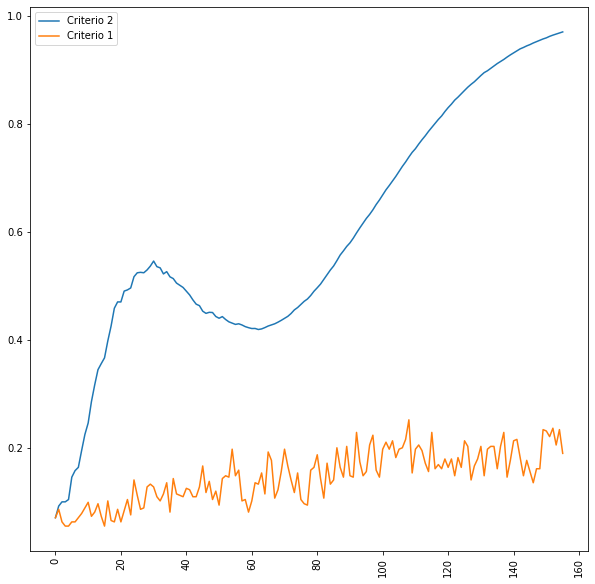

In [250]:
# C promedio personas 
plt.figure(3,figsize=(10,10)) 
plt.plot(years, C_average_p_2_month_Rw, label = 'Criterio 2')
plt.plot(years, C_average_p_1_month_Rw, label = 'Criterio 1')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

[]

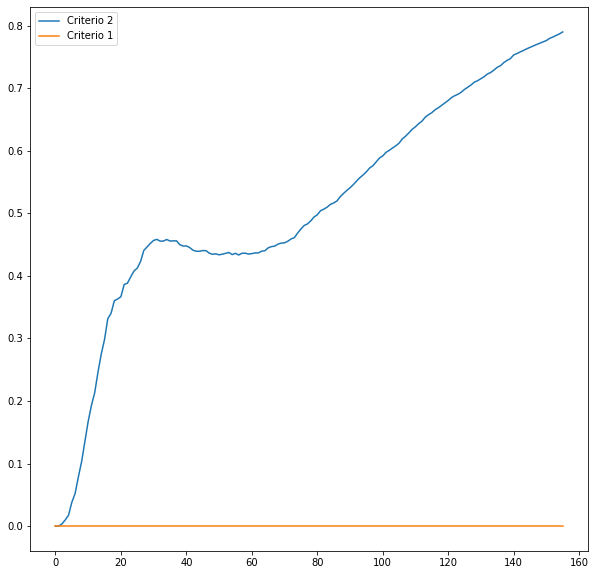

In [251]:
# C promedio empresas 
plt.figure(3,figsize=(10,10)) 
plt.plot(years, C_average_c_2_month_Rw, label = 'Criterio 2')
plt.plot(years, C_average_c_1_month_Rw, label = 'Criterio 1')
plt.legend()
plt.plot()

# Promedios Rw

In [522]:
graphs_list_Rw_list = []
companys_list = []
people_list = []
years_list = []
for element in glob.glob('.\Visits_Rw\*.dat'):
    #Leemos el grafo
    graphs_list_Rw, companys, people, years = random_walk_list(element)
    graphs_list_Rw_list.append(graphs_list_Rw)
    companys_list.append(companys)
    people_list.append(people)
    years_list.append(years)

In [ ]:
#People
graphs_list_p_month_Rw_list = []
for i in range(len(graphs_list_Rw_list)):
    graphs_list_p_month_Rw_list.append(bipartite_list(graphs_list_Rw_list[i], people_list[i]))

In [ ]:
#C Average
C_average_p_1_month_Rw_list = []
for i in range(len(graphs_list_p_month_Rw_list)):
    C_average_p_1_month_Rw_list.append(C_average(graphs_list_p_month_Rw_list[i]))

In [ ]:
#Segundo Criterio
graphs_list_Rw_list_2 = []
for i in range(len(graphs_list_Rw_list)):
    graphs_list_Rw_list_2.append(second_criteria(graphs_list_Rw_list[i]))

In [ ]:
#People
graphs_list_p_2_month_Rw_list = []
for i in range(len(graphs_list_Rw_list_2)):
    graphs_list_p_2_month_Rw_list.append(bipartite_list(graphs_list_Rw_list_2[i], people_list[i]))

In [ ]:
#C Average
C_average_p_2_month_Rw_list = []
for i in range(len(graphs_list_p_2_month_Rw_list)):
    C_average_p_2_month_Rw_list.append(C_average(graphs_list_p_2_month_Rw_list[i]))